# Sandbox - Generate Data

This notebook is used to prototype the generate_data function, used to generate all scenarios of use of the algorithm.

---

## Imports & Config

In [1]:
! pwd

/Users/simonlejoly/Documents/Work/mimosa/tests


In [2]:
! export XLA_PYTHON_CLIENT_MEM_FRACTION=.25

In [3]:
# Jax configuration
USE_JIT = False
USE_X64 = True
DEBUG_NANS = False
VERBOSE = False

In [4]:
# Standard library imports
import os
os.environ['JAX_ENABLE_X64'] = str(USE_X64).lower()

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

from typing import Tuple

In [5]:
# Third party
import jax
jax.config.update("jax_disable_jit", not USE_JIT)
jax.config.update("jax_debug_nans", DEBUG_NANS)
import jax.random as jr
import jax.numpy as jnp
from jax import vmap, jit, Array
from jax.tree_util import tree_map_with_path, GetAttrKey, tree_unflatten, tree_flatten

import matplotlib.pyplot as plt
import equinox as eqx
import numpy as np

from kernax import BlockKernel, BlockDiagKernel, BatchModule, WhiteNoiseKernel, FeatureKernel, \
	VarianceKernel, AbstractKernel, SEKernel, AbstractMean, ZeroMean, ConstantMean, AffineMean, sample_hps_from_uniform_priors

In [6]:
# Local imports
from mimosa.linalg import compute_mapping
from mimosa.sampling import sample_gp
from sandbox import *  # To avoid cluttering this notebook with functions that already work

INFO:2026-02-26 18:37:47,622:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/mimosa/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2026-02-26 18:37:47,622 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/mimosa/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


In [7]:
# Config
key = jr.PRNGKey(42)

In [8]:
jax.devices()

[CpuDevice(id=0)]

---

## Plotting functions

In [9]:
def plot_processes_1D(g, m_p):
	"""
	Plot the mean process of each cluster, for each feature and output dimension, when inputs are 1D

	Clusters are rows, features are columns.
	All output dimensions are plotted as separate curves when O>1.

	:param g: Input grid. Shape (G, 1) where G is grid_size
	:param m_p: Mean processes. Shape (K, F*G, O) where K is number of clusters, F is number of features, G is grid size and O is output dimension
	"""
	# Extract dimensions from data
	K = m_p.shape[0]
	O = m_p.shape[2]
	G = g.shape[0]
	F = m_p.shape[1] // G

	# Handle subplot axes indexing - K rows × F columns
	if K == 1 and F == 1:
		fig, ax = plt.subplots(1, 1, figsize=(8, 6))
		axes = [[ax]]
	elif K == 1:
		fig, axes_arr = plt.subplots(1, F, figsize=(4*F, 4))
		axes = [axes_arr if F > 1 else [axes_arr]]
	elif F == 1:
		fig, axes_arr = plt.subplots(K, 1, figsize=(8, 4*K))
		axes = [[ax] for ax in (axes_arr if K > 1 else [axes_arr])]
	else:
		fig, axes = plt.subplots(K, F, figsize=(4*F, 4*K))
		if not isinstance(axes[0], np.ndarray):
			axes = [[ax] for ax in axes]

	grid_size_per_feature = G

	for k in range(K):
		for f in range(F):
			# Extract data for this cluster and feature
			start_idx = f * grid_size_per_feature
			end_idx = (f + 1) * grid_size_per_feature

			# Plot all output dimensions as separate curves
			for o in range(O):
				data = m_p[k, start_idx:end_idx, o]
				if O > 1:
					axes[k][f].plot(g[:, 0], data, label=f'Output {o}')
				else:
					axes[k][f].plot(g[:, 0], data)

			if O > 1:
				axes[k][f].legend()

			axes[k][f].set_xlabel('Input')
			axes[k][f].set_ylabel('Output')
			axes[k][f].set_title(f'Cluster {k}, Feature {f}')
			axes[k][f].grid(True)
			axes[k][f].set_xlim(-50, 50)
			axes[k][f].set_ylim(-10, 10)

	plt.tight_layout()
	plt.show()

In [10]:
def plot_processes_2D(g, m_p):
	"""
	Plot the mean process of each cluster, for each feature and output dimension, when inputs are 2D

	Clusters are rows, features are columns.
	Only the first output dimension (o_id=0) is plotted, as 3D surface plots can only show one output at a time.

	:param g: Input grid. Shape (G**2, 2) where G is grid_size
	:param m_p: Mean processes. Shape (K, F*G**2, O) where K is number of clusters, F is number of features, G is grid size and O is output dimension
	"""
	# Extract dimensions from data
	K = m_p.shape[0]
	O = m_p.shape[2]
	G = g.shape[0]
	F = m_p.shape[1] // G
	o_id = 0  # Always plot first output dimension for 2D inputs

	# Handle subplot axes indexing - K rows × F columns
	if K == 1 and F == 1:
		fig = plt.figure(figsize=(8, 6))
		ax = fig.add_subplot(111, projection='3d')
		axes = [[ax]]
	elif K == 1:
		fig = plt.figure(figsize=(5*F, 5))
		axes = [[fig.add_subplot(1, F, f+1, projection='3d') for f in range(F)]]
	elif F == 1:
		fig = plt.figure(figsize=(8, 5*K))
		axes = [[fig.add_subplot(K, 1, k+1, projection='3d')] for k in range(K)]
	else:
		fig = plt.figure(figsize=(5*F, 5*K))
		axes = [[fig.add_subplot(K, F, k*F + f + 1, projection='3d') for f in range(F)] for k in range(K)]

	grid_size_per_feature = G

	for k in range(K):
		for f in range(F):
			# Extract data for this cluster, feature, and first output dimension
			start_idx = f * grid_size_per_feature
			end_idx = (f + 1) * grid_size_per_feature
			data = m_p[k, start_idx:end_idx, o_id]

			# Plot 3D surface for 2D input
			axes[k][f].plot_trisurf(g[:, 0], g[:, 1], data, cmap='viridis')
			axes[k][f].set_xlabel('Input 1')
			axes[k][f].set_ylabel('Input 2')
			axes[k][f].set_zlabel('Output')
			axes[k][f].set_title(f'Cluster {k}, Feature {f}, Output {o_id}')
			axes[k][f].set_xlim(-50, 50)
			axes[k][f].set_ylim(-50, 50)
			axes[k][f].set_zlim(-10, 10)

	plt.tight_layout()
	plt.show()

In [11]:
def plot_task_means_1D(g, m_p, full_i, task_means, mix):
	"""
	Plot the mean process of each cluster with individual tasks points overlaid, for 1D inputs

	Clusters are rows, features are columns.
	Tasks are plotted on top of their assigned cluster's mean process, as points.
	All output dimensions are plotted as separate curves when O>1.

	:param g: Input grid. Shape (G, 1) where G is grid_size
	:param m_p: Mean processes. Shape (K, F*G, O)
	:param full_i: Task inputs. Shape (T, F*N, I)
	:param task_means: Task means. Shape (T, F*N, O)
	:param mix: Task-to-cluster assignment. Shape (T,)
	"""
	# Extract dimensions from data
	K = m_p.shape[0]
	O = task_means.shape[2]  # Output dimensions (same as m_p.shape[2])
	G = g.shape[0]
	F = m_p.shape[1] // G
	T = task_means.shape[0]
	N = full_i.shape[1] // F  # Number of points per feature

	# Handle subplot axes indexing - K rows × F columns
	if K == 1 and F == 1:
		fig, ax = plt.subplots(1, 1, figsize=(8, 6))
		axes = [[ax]]
	elif K == 1:
		fig, axes_arr = plt.subplots(1, F, figsize=(4*F, 4))
		axes = [axes_arr if F > 1 else [axes_arr]]
	elif F == 1:
		fig, axes_arr = plt.subplots(K, 1, figsize=(8, 4*K))
		axes = [[ax] for ax in (axes_arr if K > 1 else [axes_arr])]
	else:
		fig, axes = plt.subplots(K, F, figsize=(4*F, 4*K))
		if not isinstance(axes[0], np.ndarray):
			axes = [[ax] for ax in axes]

	grid_size_per_feature = G

	# Define colors for each output dimension
	colors = plt.cm.tab10(range(O))

	for k in range(K):
		for f in range(F):
			# Extract and plot mean process for this cluster and feature
			start_idx = f * grid_size_per_feature
			end_idx = (f + 1) * grid_size_per_feature

			# Plot all output dimensions as separate curves
			for o in range(O):
				data = m_p[k, start_idx:end_idx, o]
				axes[k][f].plot(g[:, 0], data, label=f'Mean Process Output {o}' if O > 1 else 'Mean Process',
				               color=colors[o], linewidth=2, alpha=0.5)

			# Overlay tasks that belong to this cluster
			for t in range(T):
				if mix[t] == k:
					# Extract task inputs and means for this feature
					task_start_idx = f * N
					task_end_idx = (f + 1) * N

					task_inputs = full_i[t, task_start_idx:task_end_idx, 0]  # Shape (N,)
					task_outputs = task_means[t, task_start_idx:task_end_idx, :]  # Shape (N, O)

					# Plot all output dimensions
					for o in range(O):
						axes[k][f].plot(task_inputs, task_outputs[:, o],
						               color=colors[o], alpha=0.3, marker='.', linestyle='None'),
						               # label=f'Task {t} Output {o}' if f == 0 and O > 1 else (f'Task {t}' if f == 0 else ''))

			axes[k][f].set_xlabel('Input')
			axes[k][f].set_ylabel('Output')
			axes[k][f].set_title(f'Cluster {k}, Feature {f}')
			axes[k][f].grid(True)
			axes[k][f].set_xlim(-50, 50)
			axes[k][f].set_ylim(-10, 10)

			# Only show legend on the first subplot to avoid clutter
			if k == 0 and f == 0:
				axes[k][f].legend(fontsize=8, loc='best')

	plt.tight_layout()
	plt.show()

---

---

## Generation sub-functions

In [12]:
def generate_grid(n_points, n_dims, bounds):
    """
    Generate a regular grid in n_dims with n_points along each dimension, bounded by bounds

    Args:
        n_points: Nb point per dimension (granularity of the grid)
        n_dims: Nb of dimensions
        bounds: bounds of values in the grid

    Returns:
        Un array de shape (n_points**n_dims, n_dims) contenant toutes les combinaisons
    """
    axis = jnp.linspace(bounds[0], bounds[1], n_points)

    grids = jnp.meshgrid(*([axis] * n_dims), indexing='ij')

    return jnp.stack(grids, axis=-1).reshape(-1, n_dims)

In [13]:
"""
def sample_inputs(key, grid, T, F, N, shared_inputs_in_tasks, shared_inputs_in_features):
	if shared_inputs_in_tasks:
		if shared_inputs_in_features:
			# The input grid is unique to all tasks and features
			inputs = jr.choice(key, grid, (N,), replace=False)  # Shape (N, I)
			mappings = compute_mapping(grid, inputs)  # Shape (N,)

			#inputs = inputs[None, None, :, :]  # Shape (1, 1, N, I)
			#inputs = jnp.broadcast_to(inputs, (T, F, N, I))  # Shape (T, F, N, I)
		else:
			# The input grid is unique to all tasks but varies between features
			inputs = jr.choice(key, grid, (F, N), replace=False)  # Shape (F, N, I)
			mappings = vmap(lambda i: compute_mapping(grid, i))(inputs)  # Shape (F, N)

			#inputs = inputs[None, :, :, :]  # Shape (1, F, N, I)
			#inputs = jnp.broadcast_to(inputs, (T, F, N, I))  # Shape (T, F, N, I)
	else:
		if shared_inputs_in_features:
			# The input grid varies between tasks but is shared between features
			inputs = jr.choice(key, grid, (T, N), replace=False)  # Shape (T, N, I)
			mappings = vmap(lambda i: compute_mapping(grid, i))(inputs)  # Shape (T, N)

			#inputs = inputs[:, None, :, :]  # Shape (T, 1, N, I)
			#inputs = jnp.broadcast_to(inputs, (T, F, N, I))  # Shape (T, F, N, I)
		else:
			# The input grid varies between tasks and between features within each task
			inputs = jr.choice(key, grid, (T, F, N), replace=False)  # Shape (T, F, N, I)
			mappings = vmap(vmap(lambda i: compute_mapping(grid, i)))(inputs)  # Shape (T, F, N)

	return inputs, mappings
"""
def sample_inputs(key, grid, T, F, N, shared_inputs_in_tasks, shared_inputs_in_features):
	if shared_inputs_in_tasks:
		if shared_inputs_in_features:
			inputs = jr.choice(key, grid, (N,), replace=False)
			mappings = compute_mapping(grid, inputs)
		else:
			inputs = vmap(lambda k: jr.choice(k, grid, (N,), replace=False))(jr.split(key, F))
			mappings = vmap(lambda i: compute_mapping(grid, i))(inputs)
	else:
		if shared_inputs_in_features:
			inputs = vmap(lambda k: jr.choice(k, grid, (N,), replace=False))(jr.split(key, T))
			mappings = vmap(lambda i: compute_mapping(grid, i))(inputs)
		else:
			inputs = vmap(lambda k1: vmap(lambda k2: jr.choice(k2, grid, (N,), replace=False))(jr.split(k1, F)))(jr.split(key, T))
			mappings = vmap(vmap(lambda i: compute_mapping(grid, i)))(inputs)
	return inputs, mappings

In [14]:
def build_mean(
		mean: AbstractMean,
		O: int,
		K: int,
		shared_output_hps: bool = True,
		shared_cluster_hps: bool = True,):
	"""
	Build the mean for data generation based on specified hyperparameter structure.

	:param mean:
	:param O:
	:param K:
	:param shared_output_hps:
	:param shared_cluster_hps:
	:return: the batched mean for data generation
	"""
	# multi-output HPs
	if not shared_output_hps:
		mean = BatchModule(mean, batch_size=O, batch_in_axes=0, batch_over_inputs=False)
	else:
		mean = BatchModule(mean, batch_size=1, batch_in_axes=None, batch_over_inputs=False)

	# cluster HPs
	if not shared_cluster_hps:
		mean = BatchModule(mean, batch_size=K, batch_in_axes=0, batch_over_inputs=False)
	else:
		mean = BatchModule(mean, batch_size=1, batch_in_axes=None, batch_over_inputs=False)

	return mean

In [15]:
def build_mean_kernel(
		mean_kernel: AbstractKernel,
		O: int,
		K: int,
		shared_output_hps: bool = True,
		shared_cluster_hps: bool = True):
	"""
	Build the mean kernel for data generation based on specified hyperparameter structure.

	:param mean_kernel:
	:param O:
	:param K:
	:param shared_output_hps:
	:param shared_cluster_hps:
	:return: the batched mean kernel for data generation

	N.b: The kernel provided to this function should be the "base" kernel, i.e. the one that would be used if all HPs were shared. This function will then wrap it in the appropriate BatchModule to create the final kernel with the desired structure of HP sharing.

	That means that if F > 1, this function expects a kernel that is already wrapped in a BlockKernel to handle the multi-feature structure, and it will add additional BatchModules on top of it to handle the multi-output, cluster, and task structures. If F=1, it expects a standard kernel and will wrap it in a BlockKernel with 1 block (effectively doing nothing) before adding the BatchModules for the other structures.

	Hence, this function doesn't manage the configs relative to features.
	"""
	# multi-output HPs
	if not shared_output_hps:
		mean_kernel = BatchModule(mean_kernel, batch_size=O, batch_in_axes=0, batch_over_inputs=False)
	else:
		mean_kernel = BatchModule(mean_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=False)

	# cluster HPs
	if not shared_cluster_hps:
		mean_kernel = BatchModule(mean_kernel, batch_size=K, batch_in_axes=0, batch_over_inputs=False)
	else:
		mean_kernel = BatchModule(mean_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=False)

	return mean_kernel

In [16]:
def build_task_kernel(
		task_kernel: AbstractKernel,
		T: int,
		O: int,
		K: int,
		shared_output_hps: bool = True,
		shared_task_hps: bool = True,
		cluster_hps_in_tasks: bool = False,
		shared_inputs_in_tasks: bool = True):
	"""
	Build the task kernel for data generation based on specified hyperparameter structure.

	:param task_kernel:
	:param T:
	:param O:
	:param K:
	:param shared_output_hps:
	:param shared_task_hps:
	:param cluster_hps_in_tasks:
	:param shared_inputs_in_tasks:
	:return: the batched task kernel for data generation

	N.b: The kernel provided to this function should be the "base" kernel, i.e. the one that would be used if all HPs were shared. This function will then wrap it in the appropriate BatchModule to create the final kernel with the desired structure of HP sharing.

	That means that if F > 1, this function expects a kernel that is already wrapped in a BlockKernel to handle the multi-feature structure, and it will add additional BatchModules on top of it to handle the multi-output, cluster, and task structures. If F=1, it expects a standard kernel and will wrap it in a BlockKernel with 1 block (effectively doing nothing) before adding the BatchModules for the other structures.

	Hence, this function doesn't manage the configs relative to features.
	"""
	# multi-output HPs
	if not shared_output_hps:
		task_kernel = BatchModule(task_kernel, batch_size=O, batch_in_axes=0, batch_over_inputs=False)
	else:
		task_kernel = BatchModule(task_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=False)

	# cluster HPs
	if cluster_hps_in_tasks:
		task_kernel = BatchModule(task_kernel, batch_size=K, batch_in_axes=0, batch_over_inputs=False)
	else:
		task_kernel = BatchModule(task_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=False)

	# task HPs
	if shared_task_hps:
		if shared_inputs_in_tasks:
			task_kernel = BatchModule(task_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=False)
		else:
			task_kernel = BatchModule(task_kernel, batch_size=1, batch_in_axes=None, batch_over_inputs=True)
	else:
		if shared_inputs_in_tasks:
			task_kernel = BatchModule(task_kernel, batch_size=T, batch_in_axes=0, batch_over_inputs=False)
		else:
			task_kernel = BatchModule(task_kernel, batch_size=T, batch_in_axes=0, batch_over_inputs=True)

	return task_kernel

---

## Ablation functions

Function that remove points/output dims/cluster tasks at random

---

## Full generation function

In [17]:
def generate_data(
		key,
		T:int, K:int, F:int, N:int, I:int, O:int, grid_size: int,
		mean: eqx.Module, mean_kernel: AbstractKernel, task_kernel: AbstractKernel,
		mean_priors: dict, mean_kernel_priors: dict, task_kernel_priors: dict,
		shared_task_hps: bool = True,
		shared_cluster_hps: bool = True,
		cluster_hps_in_tasks: bool = False,
		feature_hps:bool = False,
		shared_output_hps:bool = True,
		shared_inputs_in_tasks: bool = True,
		shared_inputs_in_features: bool = True,
		input_range:Tuple[int, int] = (-50, 50),
):
	"""
	--- PRNG parameters ---
	:param key: `jax.random` PRNG key

	--- Dataset size parameters ---
	:param T: Number of tasks
	:param K: Number of clusters
	:param F: Number of features
	:param N: Number of points for each feature of each task
	:param I: Dimension of input points
	:param O: Dimension of output points

	--- Hyper-parameters modules ---
	:param mean: The mean used as a prior to sample cluster mean processes
	:param mean_kernel: The kernel used as a prior to sample cluster mean processes
	:param task_kernel: The kernel used as a prior to sample task processes
	:param mean_priors: Dictionary of priors for `mean`, aka min and max bounds for each parameter of `mean`
	:param mean_kernel_priors: Dictionary of priors for `mean_kernel`, aka min and max bounds for each parameter of `mean_kernel`
	:param task_kernel_priors: Dictionary of priors for `task_kernel`, aka min and max bounds for each parameter of `task_kernel`

	--- Hyper-parameters options ---
	:param shared_task_hps: Whether tasks share hyper-parameters
	:param shared_cluster_hps: Whether clusters share hyper-parameters
	:param cluster_hps_in_tasks: Whether task have cluster-specific hyper-parameters
	:param feature_hps: Whether features share hyper-parameters
	:param shared_output_hps: Whether outputs dimensions share hyper-parameters

	--- Sampling options ---
	:param grid_size: Grid size along each dimension. Ex: if I=2 and grid_size=10, inputs will be sampled from a regular 2D grid containing 10**2 = 100 points, from [input_range[0], input_range[0]] to [input_range[1], input_range[1]]
	:param shared_inputs_in_tasks: Whether all tasks are observed on the same sampled grid
	:param shared_inputs_in_features: Whether all features are observed on the same sampled grid

	--- Configuration parameters ---
	:param input_range: Min and max value for input points (applied to every input dimensions)

	:return: a tuple containing:
		* inputs (Shape (T, F, N**I, I)),
		* outputs (Shape (T, F, N**I, O)),
		* mixture (Shape T, K)
		* mean used to generate mean processes (eqx.Module)
		* mean kernel used to generate mean processes (AbstractKernel)
		* task kernel used to generate the data (AbstractKernel)

	TODO: Adapt for multi-feature
	"""
	# Step 0: parameters checks and conversions
	assert grid_size ** I >= N, f"Cannot sample N={N} points in a grid containing {grid_size ** I} points (= {grid_size}^{I})"
	assert O > 1 or shared_output_hps, f"No need to differentiate hyper-parameters for outputs when having only {O} output dimension"
	assert K > 1 or not cluster_hps_in_tasks, f"No need for cluster-specific hyper-parameters when having only {K} cluster"
	assert F > 1 or not feature_hps, f"No need for feature-specific hyper-parameters when having only {F} feature"

	# Step 1: generate the grid
	grid = generate_grid(grid_size, I, input_range)  # Shape (G, I) where G = grid_size**I

	# Step 2: sample the input grid
	inputs, mappings = sample_inputs(key, grid, T, F, N, shared_inputs_in_tasks, shared_inputs_in_features)  # Varying shapes

	# Step 3: batch kernels
	mean = build_mean(mean, O, K, shared_output_hps, shared_cluster_hps)
	mean_kernel = build_mean_kernel(mean_kernel, O, K, shared_output_hps, shared_cluster_hps)
	task_kernel = build_task_kernel(task_kernel, T, O, K, shared_output_hps, shared_task_hps, cluster_hps_in_tasks, shared_inputs_in_tasks)

	# Step 4: sample HPs from priors
	key, subkey1, subkey2, subkey3 = jr.split(key, 4)
	mean = sample_hps_from_uniform_priors(subkey1, mean, mean_priors)
	mean_kernel = sample_hps_from_uniform_priors(subkey2, mean_kernel, mean_kernel_priors)
	task_kernel = sample_hps_from_uniform_priors(subkey3, task_kernel, task_kernel_priors)

	# Step 5: sample mean processes for each cluster from the mean and mean kernel, evaluated on the grid
	# Adapt grid if we are in multi-feature and features don't share inputs, to create a separate grid for each feature
	if not shared_inputs_in_features:
		grid = jnp.tile(grid, (F,) + (1,) * grid.ndim)  # Shape (F*G, I)

	mean_process_means = mean(grid)  # Shape (K, O, F*G) with K=1 if shared_cluster_hps and O=1 if shared_output_hps
	mean_process_covs = mean_kernel(grid)  # Shape (K, O, F*G, F*G) with K=1 if shared_cluster_hps and O=1 if shared_output_hps

	if shared_output_hps:
		sample_outputs = vmap(lambda k, m, c: sample_gp(k, m[0], c[0]), in_axes=(0, None, None))
		if shared_cluster_hps:
			sample_clusters = vmap(lambda k, m, c: sample_outputs(k, m[0], c[0]), in_axes=(0, None, None))
		else:
			sample_clusters = vmap(lambda k, m, c: sample_outputs(k, m, c), in_axes=(0, 0, 0))
	else:
		sample_outputs = vmap(lambda k, m, c: sample_gp(k, m, c), in_axes=(0, 0, 0))
		if shared_cluster_hps:
			sample_clusters = vmap(lambda k, m, c: sample_outputs(k, m[0], c[0]), in_axes=(0, None, None))
		else:
			sample_clusters = vmap(lambda k, m, c: sample_outputs(k, m, c), in_axes=(0, 0, 0))
	key, subkey = jr.split(key)
	subkeys = jr.split(subkey, (K, O))

	mean_processes = sample_clusters(subkeys, mean_process_means, mean_process_covs)  # Shape (K, O, F*G)

	# Step 6: assign tasks to clusters
	mixture = jnp.argmax(jnp.eye(K)[jnp.array(jnp.floor(jnp.arange(T) / T * K), dtype=int)], axis=1)  # Shape (T,)

	# Step 6: sample task processes for each task from the task kernel, evaluated on the task inputs
	task_means_on_grid = mean_processes[mixture, ...]  # Shape (T, O, F*G)
	task_means = vmap(lambda t_m, m: t_m[:, m], in_axes=(0, None if shared_inputs_in_tasks else 0))(task_means_on_grid, mappings)  # Shape (T, O, F*N)

	task_covs = task_kernel(inputs)  # Shape (T, K, O, F*N, F*N), with T=1 if shared_task_hps, K=1 if not cluster_hps_in_tasks and O=1 if shared_output_hps
	if cluster_hps_in_tasks:
		# Select covariance from the "right" cluster for each task
		task_covs = task_covs[jnp.arange(len(task_covs)), mixture]  # Shape (T, O, F*N, F*N) with T=1 if shared_task_hps and O=1 if shared_output_hps
	else:
		task_covs = task_covs[:, 0, ...]  # Shape (T, O, F*N, F*N) with T=1 if shared_task_hps and O=1 if shared_output_hps

	if shared_output_hps:
		sample_outputs = vmap(lambda k, m, c: sample_gp(k, m, c[0]), in_axes=(0, 0, None))
		if shared_task_hps:
			sample_tasks = vmap(lambda k, m, c: sample_outputs(k, m, c[0]), in_axes=(0, 0, None))
		else:
			sample_tasks = vmap(lambda k, m, c: sample_outputs(k, m, c), in_axes=(0, 0, 0))
	else:
		sample_outputs = vmap(lambda k, m, c: sample_gp(k, m, c), in_axes=(0, 0, 0))
		if shared_task_hps:
			sample_tasks = vmap(lambda k, m, c: sample_outputs(k, m, c[0]), in_axes=(0, 0, None))
		else:
			sample_tasks = vmap(lambda k, m, c: sample_outputs(k, m, c), in_axes=(0, 0, 0))
	key, subkey = jr.split(key)
	subkeys = jr.split(subkey, (T, O))

	outputs = sample_tasks(subkeys, task_means, task_covs).transpose(0, 2, 1)  # Shape (T, F*N, O)

	return inputs, outputs, mappings, grid, mean_process_means, mean_process_covs, mean_processes, mixture, task_means, mean, mean_kernel, task_kernel

---

## Usage

In [18]:
mean_priors = {
	"slope": (-.2, .2),
	"intercept": (-2.5, 2.5)
}

mean_kernel_priors = {
	"variance": (5, 10.),
	"length_scale": (2.5, 10.)
}

task_kernel_priors = {
	"variance": (0.25, 1.),
	"length_scale": (2., 8.),
	"noise": (0.01, 0.1)
}

In [19]:
key, k = jr.split(key)
T=9 ; K=3 ; F=1 ; N=25 ; I=1 ; O=2 ; gs=250 if I == 1 else 40

sth=True ; sch=True ; chit=True ; fh=False ; soh=False ; siit=True ; siif=True

mean = AffineMean(slope=0., intercept=0.)
mean_kernel = VarianceKernel(20.) * SEKernel(length_scale=10.)
task_kernel = VarianceKernel(.2) * SEKernel(length_scale=9.) + WhiteNoiseKernel(noise=.01)

#                     generate_data(k, T, K, F, N,  I, O, G,  sth,   ch,    fh,   ai,   soh,   siit,  siif)
_ = generate_data(k, T, K, F, N,  I, O, gs, mean, mean_kernel, task_kernel, mean_priors, mean_kernel_priors, task_kernel_priors, sth, sch, chit, fh, soh, siit, siif)

In [20]:
inputs, outputs, maps, grid, m_p_means, m_p_covs, m_p, mix, t_m, m, m_k, t_k = generate_data(k, T, K, F, N,  I, O, gs, mean, mean_kernel, task_kernel, mean_priors, mean_kernel_priors, task_kernel_priors, sth, sch, chit, fh, soh, siit, siif)

In [21]:
print(m)

AffineMean(slope=[-0.00 ± 0.12]₂, intercept=[1.89 ± 0.00]₂)


In [22]:
print(m_k)

VarianceKernel(variance=[8.86 ± 0.11]₂) * SEKernel(length_scale=[7.81 ± 2.16]₂)


In [23]:
print(t_k)

VarianceKernel(variance=[0.54 ± 0.14]₃ₓ₂) * SEKernel(length_scale=[4.73 ± 1.69]₃ₓ₂) + WhiteNoiseKernel(noise=[0.04 ± 0.03]₃ₓ₂)


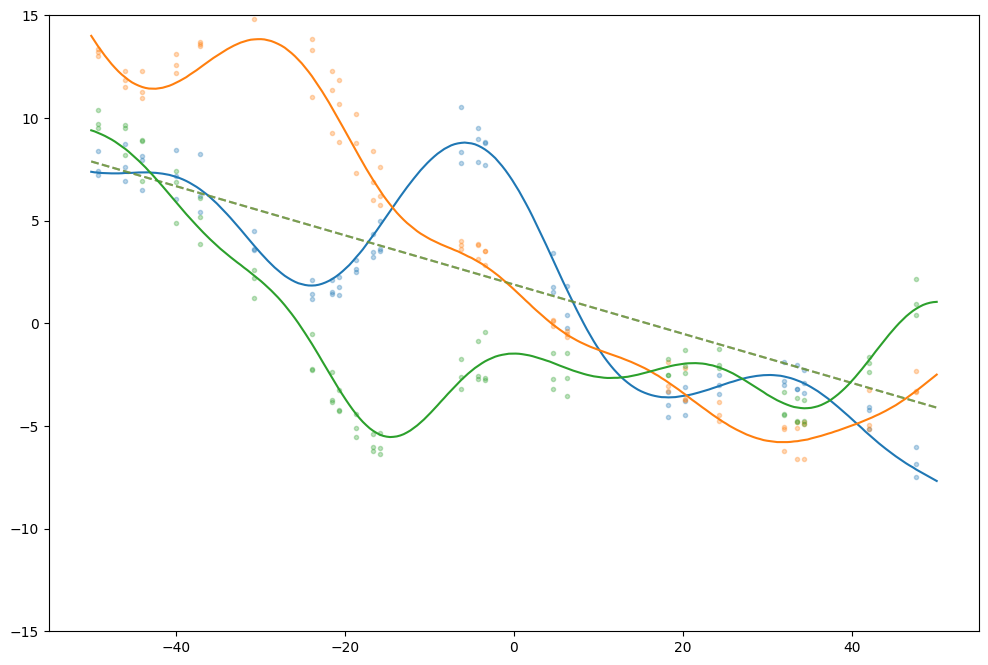

In [24]:
o_i = 0
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(range(K))
for k_i in range(K):
	# Print the hyper-prior
	plt.plot(grid[:, 0], m(grid)[k_i, 0, :], color=colors[k_i], linestyle='--', alpha=.5)

	# Print the mean process for this cluster and output dimension
	plt.plot(grid[:, 0], m_p[k_i, o_i, :], color=colors[k_i])

	# Print the tasks that belong to this cluster as points
	if siit:
		for t_i in range(len(outputs[mix == k_i])):
			plt.plot(inputs[:, 0], outputs[mix == k_i][t_i, :, o_i], marker='.', linestyle='None', color=colors[k_i], alpha=0.3)
	else:
		for t_i in range(len(inputs[mix == k_i])):
			plt.plot(inputs[mix == k_i][t_i, :, 0], outputs[mix == k_i][t_i, :, o_i], marker='.', linestyle='None', color=colors[k_i], alpha=0.3)
plt.xlim(-55, 55)
plt.ylim(-15, 15)
plt.show()

In [25]:
0/0

ZeroDivisionError: division by zero

In [ ]:
# Check for errors
for sth in (True, False):
	for sch in (True, False):
		for chit in (True, False):
			#for fh in (True, False):
				for I in (1, 2):
					for soh in (True, False):
						for siit in (True, False):
							#for siif in (True, False):
								try:
									k = jr.PRNGKey(42)
									generate_data(k, T, K, F, N,  I, O, gs, mean, mean_kernel, task_kernel, mean_priors, mean_kernel_priors, task_kernel_priors, sth, sch, chit, fh, soh, siit, siif)
									print(f"OK - {sth}, {sch}, {chit}, {fh}, {I}, {soh}, {siit}, {siif}")
								except Exception as e:
									print(f"KO - {sth}, {sch}, {chit}, {fh}, {I}, {soh}, {siit}, {siif}\n\t{e}")

OK - True, True, True, False, 1, True, True, True
OK - True, True, True, False, 1, True, False, True
OK - True, True, True, False, 1, False, True, True
OK - True, True, True, False, 1, False, False, True


---

## Sandbox

---